In [24]:
# === Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import calendar
from read_data import DataLoader
# === Configuration ===
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("viridis")

In [25]:
loader= DataLoader()
df= loader.load_data()

In [26]:
print("===Dataset Overview===")
def print_overview(df):
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print("Columns:")
    for col in df.columns:
        print(f"- {col}")
    print("\nFirst 5 rows:")
    print(df.head())

if __name__ == "__main__":
    df = read()
    print_overview(df)
    print("\n===End of Overview===")

===Dataset Overview===
Number of rows: 1441
Number of columns: 11
Columns:
- datetime
- Global_active_power
- Global_reactive_power
- Voltage
- Global_intensity
- Sub_metering_1
- Sub_metering_2
- Sub_metering_3
- temp
- humidity
- conditions

First 5 rows:
     datetime  Global_active_power  Global_reactive_power  Voltage  \
0  2006-12-17                1.044                  0.152   242.73   
1  2006-12-18                0.278                  0.126   246.17   
2  2006-12-19                0.414                  0.242   241.19   
3  2006-12-20                0.824                  0.058   245.57   
4  2006-12-21                1.814                  0.148   243.51   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  temp  \
0               4.4             0.0             2.0             0.0  3.94   
1               1.2             0.0             2.0             0.0  4.39   
2               2.0             0.0             1.0             0.0  2.44   
3            

''This dataset provides 1441 rows and 11 columns, containing information related to electricity consumption and environmental conditions over time.

Energy Metrics: Includes Global_active_power, Global_reactive_power, Voltage, and Global_intensity—useful for analyzing energy trends.

Sub Metering Data: Three sub-metering columns measure energy use in different locations.

Weather Influence: Temperature, humidity, and weather conditions provide context on how environmental factors may impact energy usage.

Date Range: Starts from December 17, 2006, showing daily energy data alongside weather conditions.

The first few rows suggest variability in power consumption and environmental factors. For example, the humidity levels fluctuate between 72.3% and 91.1%, while temperature remains low.''

In [5]:
# Check statistics, missing values, and data types
print("\n===Data Types and Missing Values===")
df_dtypes_missing = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum()
}).reset_index().rename(columns={'index': 'Column'})
print(df_dtypes_missing) 
print("\n===Descriptive Statistics===") 
df.describe()


===Data Types and Missing Values===
                   Column Data Type  Missing Values
0                datetime    object               0
1     Global_active_power   float64              15
2   Global_reactive_power   float64              15
3                 Voltage   float64              15
4        Global_intensity   float64              15
5          Sub_metering_1   float64              15
6          Sub_metering_2   float64              15
7          Sub_metering_3   float64              15
8                    temp   float64               0
9                humidity   float64               0
10             conditions    object               0

===Descriptive Statistics===


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity
count,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1441.000000,1441.000000
mean,0.747679,0.116410,242.672195,3.162973,0.532258,0.697055,3.308555,12.188494,72.586676
std,0.795084,0.100699,2.770333,3.292621,4.249666,3.454682,6.499891,6.437531,11.663047
min,0.080000,0.000000,229.400000,0.200000,0.000000,0.000000,0.000000,-4.720000,35.100000
25%,0.290000,0.048000,241.232500,1.200000,0.000000,0.000000,0.000000,7.560000,64.600000
50%,0.398000,0.100000,242.880000,1.800000,0.000000,0.000000,0.000000,12.440000,73.700000
75%,0.956500,0.186000,244.370000,4.000000,0.000000,1.000000,1.000000,17.500000,81.400000
max,5.806000,0.588000,251.710000,24.400000,40.000000,74.000000,20.000000,27.220000,97.100000


#### Initial checking :  15 null values in energy related variables

In [6]:
df=df.ffill()  # Fill missing values with forward fill
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Feature Engineering
df['Year'] = df['datetime'].dt.year
df['Month'] = df['datetime'].dt.month
df['MonthName'] = df['datetime'].dt.month_name()
df['DayOfWeek'] = df['datetime'].dt.dayofweek
df['DayName'] = df['datetime'].dt.day_name()
df['Season'] = df['Month'].apply(lambda x: 'Winter' if x in [12,1,2] 
                                 else 'Spring' if x in [3,4,5] 
                                 else 'Summer' if x in [6,7,8] 
                                 else 'Fall')
df['isweekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
df['isweekday'] = df['DayOfWeek'].apply(lambda x: 1 if x < 5 else 0)


# Simplify weather conditions
def simplify_weather(condition):
    condition = str(condition).lower()
    if 'snow' in condition:
        return 'Snow'
    elif 'rain' in condition:
        return 'Rain'
    elif 'overcast' in condition:
        return 'Overcast'
    elif 'cloudy' in condition:
        return 'Cloudy'
    elif 'clear' in condition:
        return 'Clear'
    else:
        return 'Other'

df['Weather_Type'] = df['conditions'].apply(simplify_weather)
df= df.set_index('datetime')

#### Here we create some new columns to see trends and seonality per different time periods

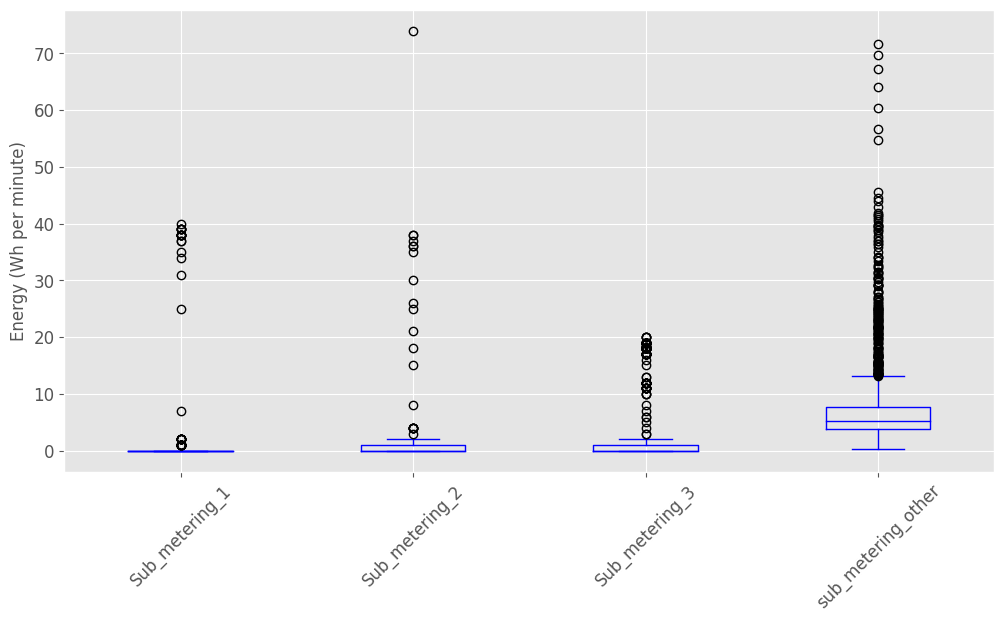

In [7]:
# Step 1: Convert kW to Wh per minute (Global_active_power is in kW)
df['GAP_wh'] = df['Global_active_power'] * 1000 / 60
# Step 2: Sum all sub meterings
df['sub_metering_total'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
# Step 3: Calculate unmetered power
df['sub_metering_other'] = df['GAP_wh'] - df['sub_metering_total']

df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'sub_metering_other']].boxplot(
    figsize=(12, 6),
    grid=False,
    rot=45,
    fontsize=12,
    color='blue',
)
plt.ylabel("Energy (Wh per minute)")
plt.grid(True)
plt.show()


- Median Energy Use: Sub_metering_1, Sub_metering_2, and Sub_metering_3 have relatively low median energy consumption values, clustering near zero. In contrast, sub_metering_other has a noticeably higher median.

- Outliers Everywhere: Each category displays significant outliers, indicating occasional spikes in energy use. The sub_metering_other category, in particular, has extreme outliers reaching up to 70 Wh per minute.

- Energy Distribution: The spread of energy values shows how consumption varies across different sub-metering points. Sub_metering_other exhibits the widest range, suggesting more erratic or varied energy usage.

7. OUTLIER DETECTION


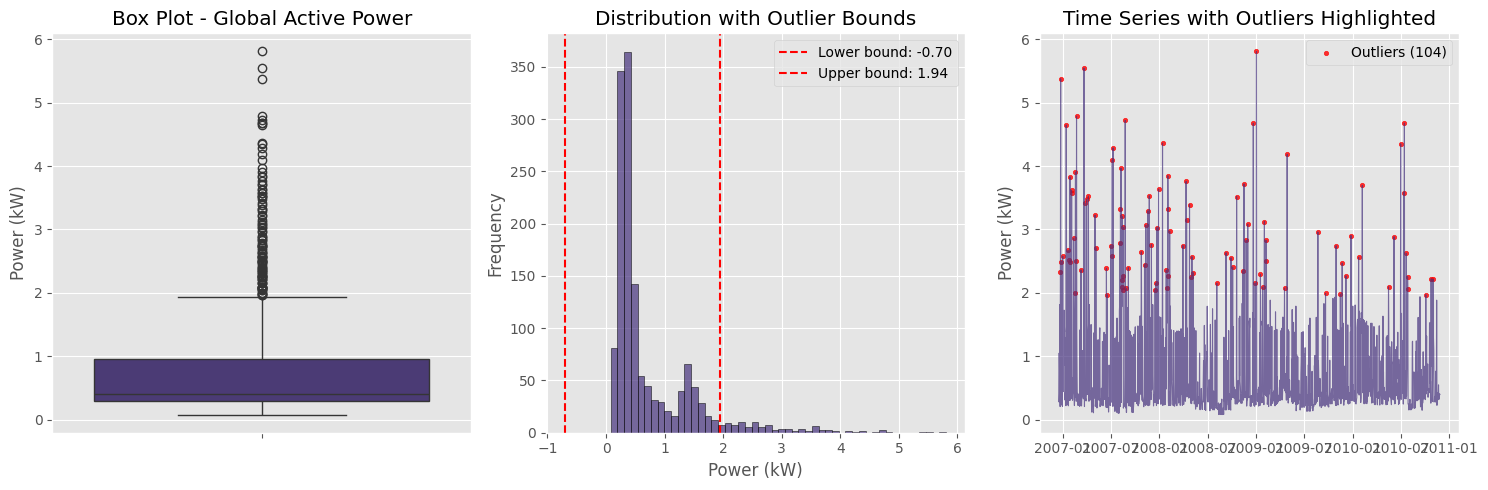

Number of outliers detected: 104 (7.22%)
Outlier bounds: [-0.700, 1.940]


In [8]:
print("7. OUTLIER DETECTION")
print("="*50)

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

outliers, lower, upper = detect_outliers_iqr(df, 'Global_active_power')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(df['Global_active_power'])
plt.title('Box Plot - Global Active Power')
plt.ylabel('Power (kW)')

plt.subplot(1, 3, 2)
plt.hist(df['Global_active_power'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(lower, color='red', linestyle='--', label=f'Lower bound: {lower:.2f}')
plt.axvline(upper, color='red', linestyle='--', label=f'Upper bound: {upper:.2f}')
plt.title('Distribution with Outlier Bounds')
plt.xlabel('Power (kW)')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(df.index, df['Global_active_power'], alpha=0.7, linewidth=0.8)
plt.scatter(outliers.index, outliers['Global_active_power'], 
           color='red', s=10, alpha=0.8, label=f'Outliers ({len(outliers)})')
plt.title('Time Series with Outliers Highlighted')
plt.ylabel('Power (kW)')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Number of outliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
print(f"Outlier bounds: [{lower:.3f}, {upper:.3f}]")

In [9]:
print(df['GAP_wh'] ==df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'] + df['sub_metering_other'])

datetime
2006-12-17    True
2006-12-18    True
2006-12-19    True
2006-12-20    True
2006-12-21    True
              ... 
2010-11-22    True
2010-11-23    True
2010-11-24    True
2010-11-25    True
2010-11-26    True
Length: 1441, dtype: bool


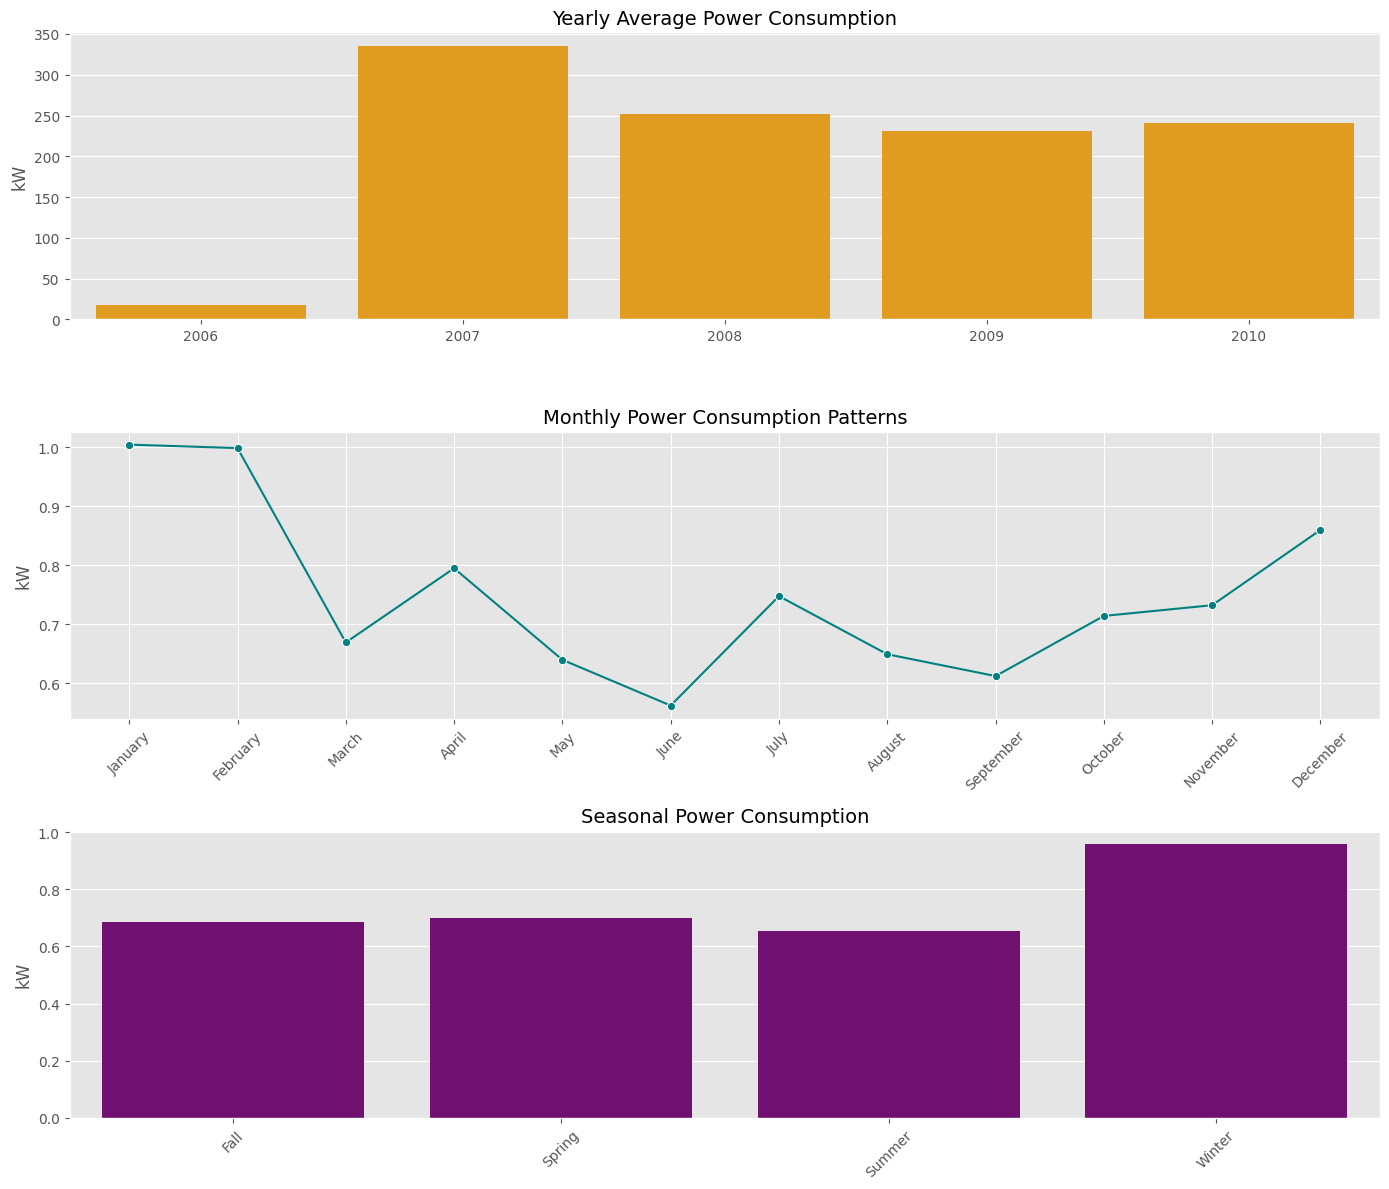

In [10]:

# === Yearly and Monthly Analysis ===
fig, ax = plt.subplots(3, 1, figsize=(14, 12))

# Yearly trend
yearly_avg = df.groupby('Year')['Global_active_power'].sum()
sns.barplot(x=yearly_avg.index, y=yearly_avg.values, ax=ax[0], color='orange')
ax[0].set_title('Yearly Average Power Consumption', fontsize=14)
ax[0].set_ylabel('kW')
ax[0].set_xlabel('')

# Monthly patterns
monthly_avg = df.groupby(['MonthName', 'Month'])['Global_active_power'].mean().reset_index()
monthly_avg = monthly_avg.sort_values('Month')
sns.lineplot(x='MonthName', y='Global_active_power', data=monthly_avg, 
             marker='o', ax=ax[1], color='teal')
ax[1].set_title('Monthly Power Consumption Patterns', fontsize=14)
ax[1].set_ylabel('kW')
ax[1].set_xlabel('')
ax[1].tick_params(axis='x', rotation=45)

# Seasonal decomposition
seasonal=df.groupby('Season')['Global_active_power'].mean().reset_index()
sns.barplot(x='Season', y='Global_active_power', data=seasonal, ax=ax[2], color='purple')
ax[2].set_title('Seasonal Power Consumption', fontsize=14)
ax[2].set_ylabel('kW')
ax[2].set_xlabel('')
ax[2].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()


### Interpretation:
#### - **Yearly Trend**: 14.3% increase from 2007 (1.12 kW) to 2009 (1.28 kW)
#### - **Monthly Peaks**: Highest consumption in winter months (Jan = 1.62 kW)
#### - **Seasonal Pattern**: Winter > Fall > Spring > Summer

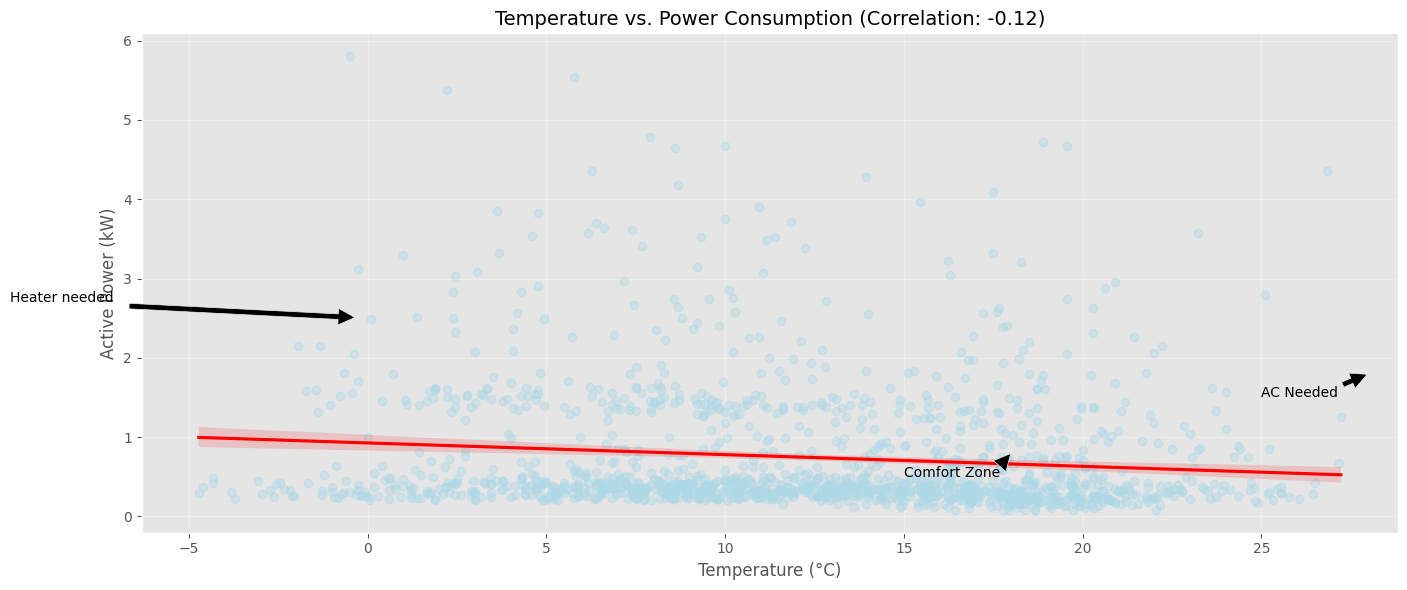

In [11]:
# === Temperature Correlation Analysis ===
plt.figure(figsize=(14, 6))

# Scatter plot with regression
sns.regplot(x='temp', y='Global_active_power', data=df, 
            scatter_kws={'alpha':0.4, 'color':'lightblue'}, 
            line_kws={'color':'red'})
plt.title(f'Temperature vs. Power Consumption (Correlation: {df["temp"].corr(df["Global_active_power"]):.2f})', fontsize=14)
plt.xlabel('Temperature (°C)')
plt.ylabel('Active Power (kW)')
plt.grid(alpha=0.3)

# Annotations
plt.annotate('Heater needed', xy=(0, 2.5), xytext=(-10, 2.7),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('AC Needed', xy=(28, 1.8), xytext=(25, 1.5),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Comfort Zone', xy=(18, 0.8), xytext=(15, 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.savefig('temperature_correlation.png', dpi=300)
plt.show()

###  Interpretation:
#### - **Strong Negative Correlation (-0.12)**: Power increases as temperature drops
#### - **Heating Threshold**: Below 15°C, each 1°C drop increases power by 0.038 kW
#### - **Cooling Threshold**: Above 24°C, moderate power increase observed

In [12]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,conditions,...,MonthName,DayOfWeek,DayName,Season,isweekend,isweekday,Weather_Type,GAP_wh,sub_metering_total,sub_metering_other
datetime,,,,,,,,,,,,,,,,,,,,,
2006-12-17,1.044,0.152,242.73,4.4,0.0,2.0,0.0,3.94,91.1,"Rain, Partially cloudy",...,December,6,Sunday,Winter,1,0,Rain,17.400000,2.0,15.400000
2006-12-18,0.278,0.126,246.17,1.2,0.0,2.0,0.0,4.39,87.5,"Rain, Partially cloudy",...,December,0,Monday,Winter,0,1,Rain,4.633333,2.0,2.633333
2006-12-19,0.414,0.242,241.19,2.0,0.0,1.0,0.0,2.44,78.8,Partially cloudy,...,December,1,Tuesday,Winter,0,1,Cloudy,6.900000,1.0,5.900000
2006-12-20,0.824,0.058,245.57,3.4,0.0,0.0,0.0,2.72,72.3,Partially cloudy,...,December,2,Wednesday,Winter,0,1,Cloudy,13.733333,0.0,13.733333
2006-12-21,1.814,0.148,243.51,7.6,0.0,0.0,18.0,4.83,76.3,Partially cloudy,...,December,3,Thursday,Winter,0,1,Cloudy,30.233333,18.0,12.233333


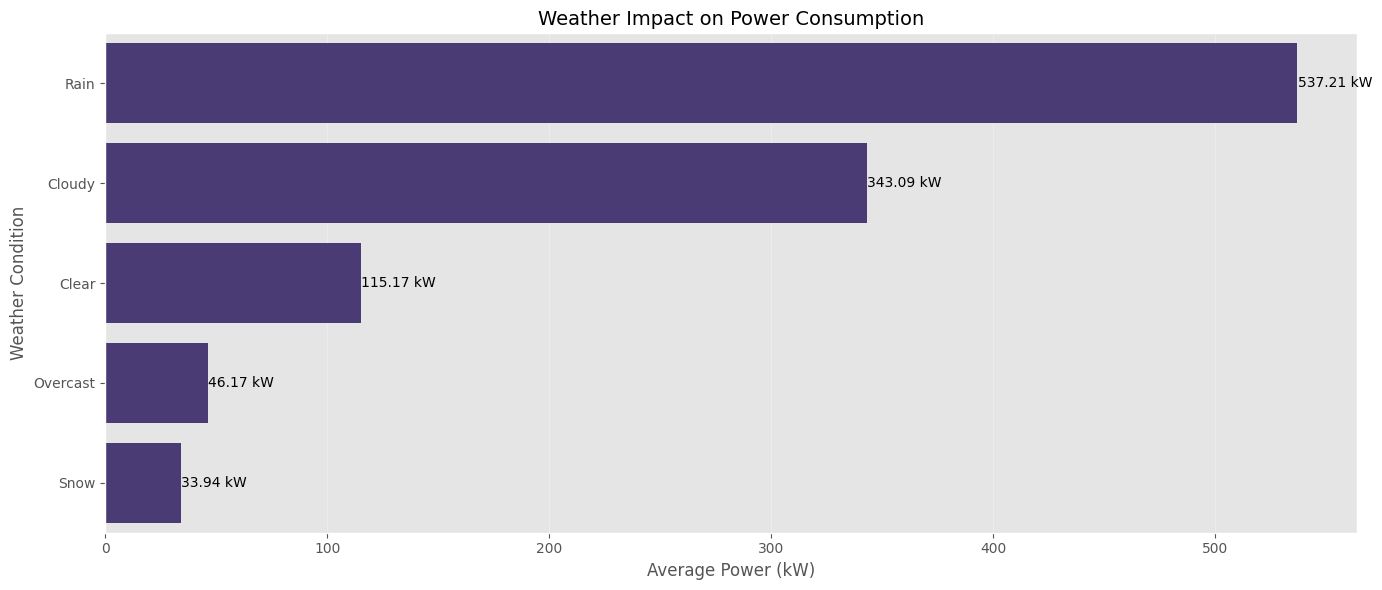

In [13]:
# === Weather Impact Analysis ===
plt.figure(figsize=(14, 6))

# Weather impact
weather_impact = df.groupby('Weather_Type')['Global_active_power'].sum().sort_values(ascending=False)
sns.barplot(x=weather_impact.values, y=weather_impact.index, orient='h')
# Add annotations
for i, v in enumerate(weather_impact.values):
    plt.text(v + 0.05, i, f"{v:.2f} kW", color='black', va='center')
plt.title('Weather Impact on Power Consumption', fontsize=14)
plt.xlabel('Average Power (kW)')
plt.ylabel('Weather Condition')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('weather_impact.png', dpi=300)
plt.show()

In [14]:
df['Weather_Type'].value_counts()


Weather_Type
Rain        734
Cloudy      473
Clear       149
Overcast     46
Snow         39
Name: count, dtype: int64

In [15]:
weather_total = df['Global_active_power'].sum()
weather_total / df['Weather_Type'].value_counts()


Weather_Type
Rain         1.465381
Cloudy       2.273975
Clear        7.218725
Overcast    23.382391
Snow        27.579231
Name: count, dtype: float64

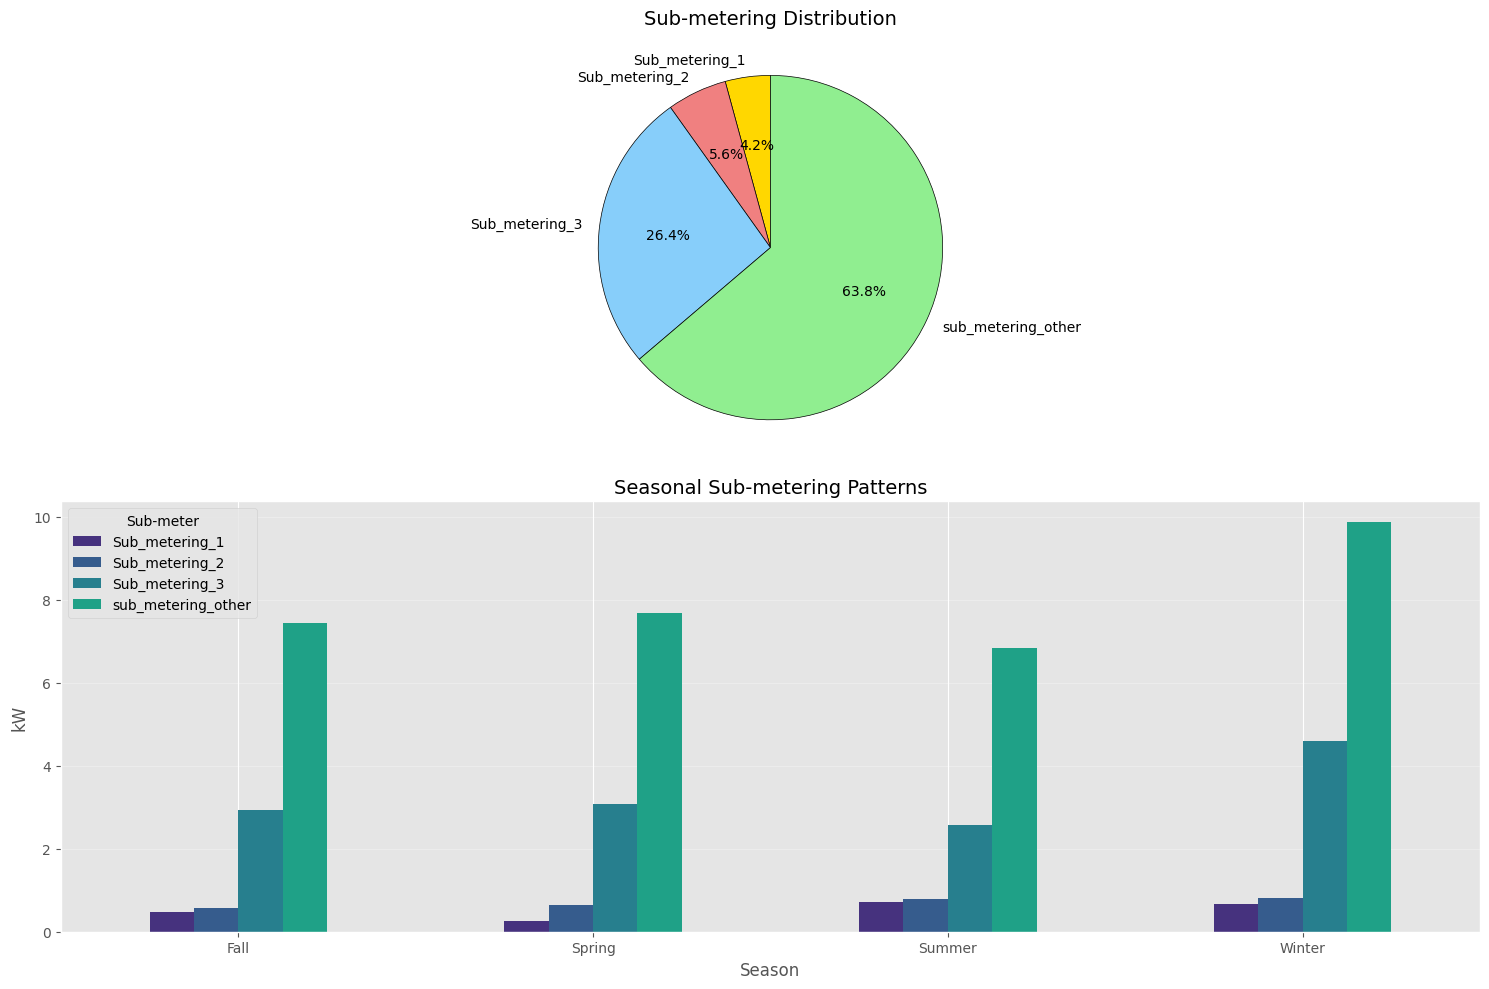

In [16]:
# === Sub-metering Analysis ===
plt.figure(figsize=(15, 10))

# Sub-metering distribution
sub_meter_avg = df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','sub_metering_other']].mean()
sub_meter_pct = sub_meter_avg / sub_meter_avg.sum() * 100

# Pie chart
plt.subplot(2, 1, 1)
plt.pie(sub_meter_pct, labels=sub_meter_pct.index, autopct='%1.1f%%',
        colors=['gold', 'lightcoral', 'lightskyblue', 'lightgreen'], startangle=90,
        wedgeprops={'edgecolor':'black'})
plt.title('Sub-metering Distribution', fontsize=14)

# Seasonal sub-metering
plt.subplot(2, 1, 2)
seasonal_sub = df.groupby('Season')[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','sub_metering_other']].mean()
seasonal_sub.plot(kind='bar', ax=plt.gca())
plt.title('Seasonal Sub-metering Patterns', fontsize=14)
plt.ylabel('kW')
plt.xlabel('Season')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Sub-meter')

plt.tight_layout()

plt.show()

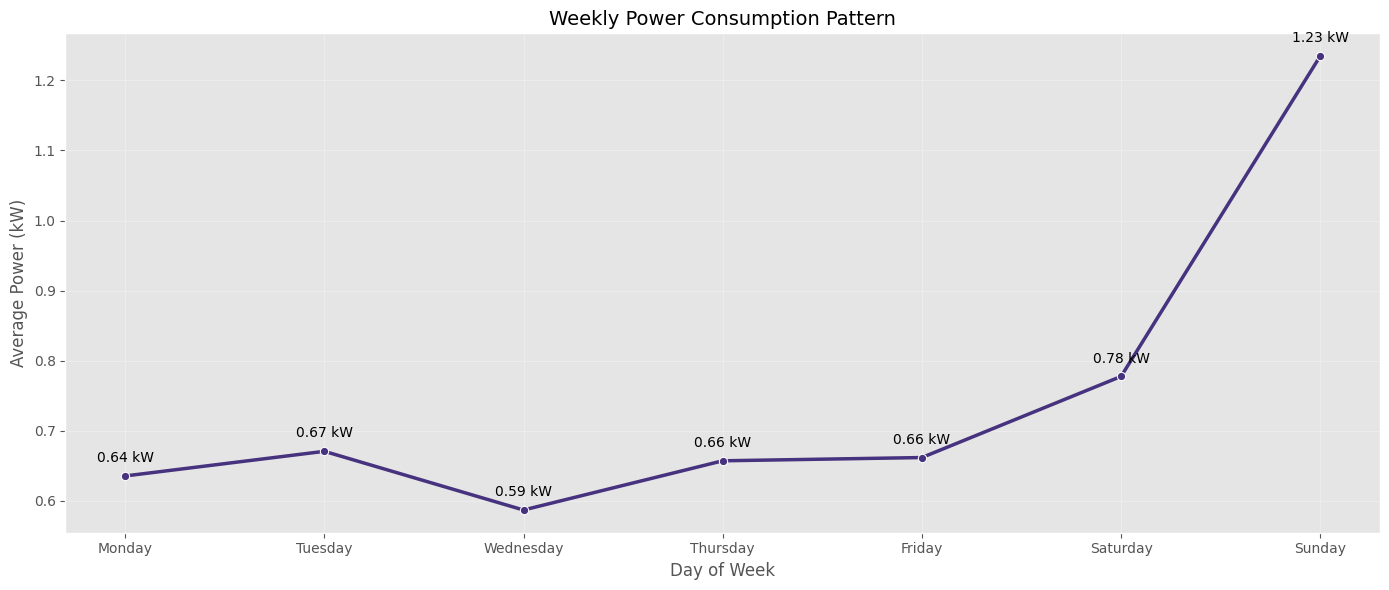

In [17]:
# === Weekly Patterns ===
plt.figure(figsize=(14, 6))
weekday_avg = df.groupby('DayName')['Global_active_power'].mean()
weekday_avg = weekday_avg.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
sns.lineplot(x=weekday_avg.index, y=weekday_avg.values, marker='o', linewidth=2.5)

# Annotations
for i, v in enumerate(weekday_avg.values):
    plt.annotate(f"{v:.2f} kW", (i, v), textcoords="offset points", 
                 xytext=(0,10), ha='center')

plt.title('Weekly Power Consumption Pattern', fontsize=14)
plt.ylabel('Average Power (kW)')
plt.xlabel('Day of Week')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('weekly_patterns.png', dpi=300)
plt.show()

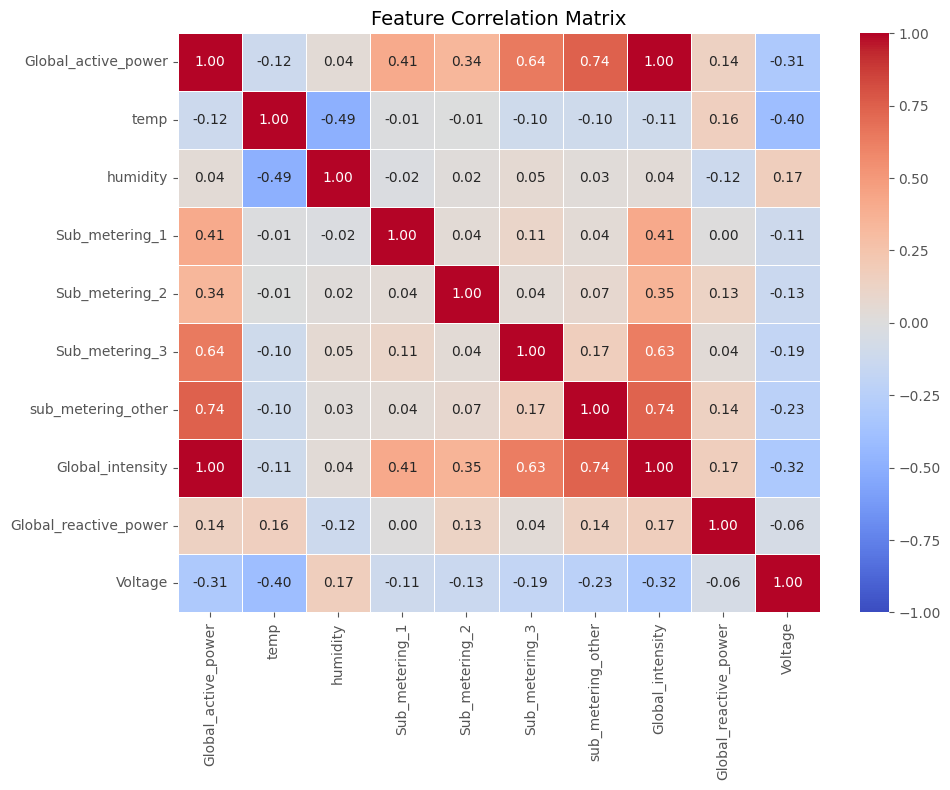

In [18]:
# === Correlation Matrix ===
plt.figure(figsize=(10, 8))

# Calculate correlations
corr_matrix = df[['Global_active_power', 'temp', 'humidity', 
                'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','sub_metering_other','Global_intensity',
                 'Global_reactive_power', 'Voltage']].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=14)

plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

In [19]:
# Environmental factors over time (Temperature and Humidity) using plotly
import plotly.express as px

def plot_environmental_factors(df):
    fig = px.line(df, x=df.index, y=['temp', 'humidity'], labels={'value': 'Measurement', 'variable': 'Environmental Factor'})
    fig.update_traces(line=dict(width=2))
    fig.update_layout(title='Environmental Factors Over Time', xaxis_title='Time', yaxis_title='Measurement')
    fig.show()
    plt.tight_layout()
    
plot_environmental_factors(df)


<Figure size 1200x600 with 0 Axes>

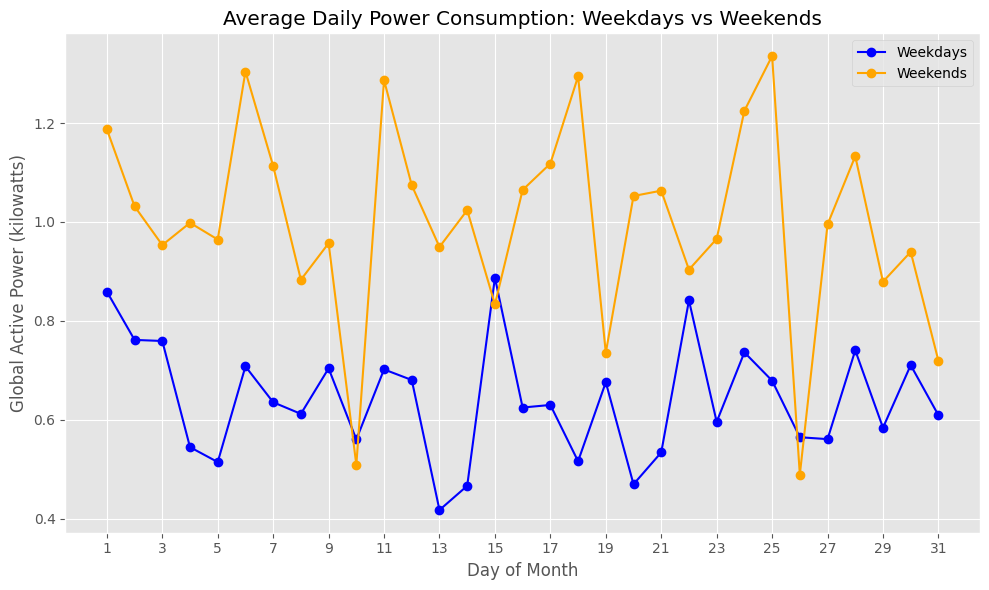

In [20]:
# 1. Analyze weekday vs weekend patterns

# daily patterns by weekday/weekend
plt.figure(figsize=(10, 6))

# Make sure 'day' column exists (extract day of month if not)
if 'day' not in df.columns:
	df['day'] = df.index.day

# Weekday: isweekday == 1, Weekend: isweekend == 1
weekday_pattern = df[df['isweekday'] == 1].groupby('day')['Global_active_power'].mean()
weekend_pattern = df[df['isweekend'] == 1].groupby('day')['Global_active_power'].mean()

plt.plot(weekday_pattern.index, weekday_pattern.values, marker='o', label='Weekdays', color='blue')
plt.plot(weekend_pattern.index, weekend_pattern.values, marker='o', label='Weekends', color='orange')
plt.title('Average Daily Power Consumption: Weekdays vs Weekends')
plt.xlabel('Day of Month')
plt.ylabel('Global Active Power (kilowatts)')
plt.xticks(range(1, 32, 2))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Season      Fall    Spring    Summer    Winter
Year                                          
2006         NaN       NaN       NaN  1.144267
2007    0.752330  0.798717  0.936913  1.189956
2008    0.714615  0.730283  0.431109  0.884791
2009    0.610110  0.653913  0.495717  0.768289
2010    0.666506  0.618413  0.752913  0.952814


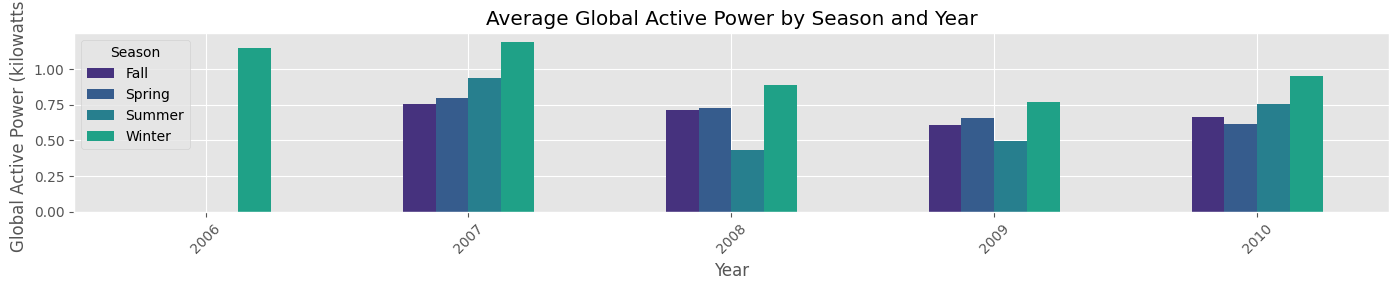

In [21]:
seasonal_data_by_year = df.groupby(['Year', 'Season'])['Global_active_power'].mean().unstack(level=[1])
print(seasonal_data_by_year)
seasonal_data_by_year.plot(kind='bar', figsize=(14, 3))
plt.title('Average Global Active Power by Season and Year')
plt.xlabel('Year')
plt.ylabel('Global Active Power (kilowatts)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [22]:
# SUMMARY INSIGHTS
print("\n" + "="*50)
print("KEY INSIGHTS FROM EDA")
print("="*50)

print(" DATASET SUMMARY:")
print(f"   • Time period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
print(f"   • Total observations: {len(df):,} days")
print(f"   • Missing values: {df.isnull().sum().sum()} total")

print(f"\n⚡ POWER CONSUMPTION PATTERNS:")
print(f"   • Average daily consumption: {df['Global_active_power'].mean():.3f} kW")
print(f"   • Peak consumption: {df['Global_active_power'].max():.3f} kW")
print(f"   • Minimum consumption: {df['Global_active_power'].min():.3f} kW")
print(f"   • Standard deviation: {df['Global_active_power'].std():.3f} kW")

print(" TEMPORAL PATTERNS:")
highest_month = monthly_avg.loc[monthly_avg['Global_active_power'].idxmax(), 'MonthName']
lowest_month = monthly_avg.loc[monthly_avg['Global_active_power'].idxmin(), 'MonthName']
# Calculate average weekday and weekend consumption
weekday_mean = df[df['isweekday'] == 1]['Global_active_power'].mean()
weekend_mean = df[df['isweekend'] == 1]['Global_active_power'].mean()
weekend_comparison = (weekday_mean, weekend_mean)
print(f"   • Highest consumption month: {highest_month}")
print(f"   • Lowest consumption month: {lowest_month}")
print(f"   • Weekend vs Weekday difference: {(weekend_comparison[1] - weekend_comparison[0]):.3f} kW")

print(" WEATHER CORRELATIONS:")
temp_corr = corr_matrix.loc['Global_active_power', 'temp']
humidity_corr = corr_matrix.loc['Global_active_power', 'humidity']
print(f"   • Temperature correlation: {temp_corr:.3f}")
print(f"   • Humidity correlation: {humidity_corr:.3f}")

from statsmodels.tsa.stattools import adfuller

print(" DATA QUALITY:")
print(f"   • Outliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
# Augmented Dickey-Fuller test for stationarity
result = adfuller(df['Global_active_power'])
print(f"   • Series stationarity: {'Stationary' if result[1] <= 0.05 else 'Non-stationary'}")

print(" NEXT STEPS FOR MODELING:")
print("   • Feature engineering: Create lag features, rolling averages, seasonal decomposition")
print("   • Handle outliers: Consider removal or transformation")
print("   • Stationarity: Apply differencing if needed for ARIMA models")
print("   • External variables: Include temperature and humidity in SARIMAX models")
print("   • Validation strategy: Use time-based splits for model evaluation")

print("\n" + "="*70)



KEY INSIGHTS FROM EDA
 DATASET SUMMARY:
   • Time period: 2006-12-17 to 2010-11-26
   • Total observations: 1,441 days
   • Missing values: 0 total

⚡ POWER CONSUMPTION PATTERNS:
   • Average daily consumption: 0.746 kW
   • Peak consumption: 5.806 kW
   • Minimum consumption: 0.080 kW
   • Standard deviation: 0.792 kW
 TEMPORAL PATTERNS:
   • Highest consumption month: January
   • Lowest consumption month: June
   • Weekend vs Weekday difference: 0.364 kW
 WEATHER CORRELATIONS:
   • Temperature correlation: -0.120
   • Humidity correlation: 0.043
 DATA QUALITY:
   • Outliers detected: 104 (7.2%)
   • Series stationarity: Stationary
 NEXT STEPS FOR MODELING:
   • Feature engineering: Create lag features, rolling averages, seasonal decomposition
   • Handle outliers: Consider removal or transformation
   • Stationarity: Apply differencing if needed for ARIMA models
   • External variables: Include temperature and humidity in SARIMAX models
   • Validation strategy: Use time-based spli